# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [22]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomRotation(3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

test_tranforms = transforms.Compose([
    # transforms.RandomRotation(30),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=test_tranforms)
# Split testset into testset (80%) and validationset (20%)
testset_size = int(len(testset) * 0.8)
validation_size = len(testset) - testset_size
testset, validationset = torch.utils.data.random_split(testset, [testset_size, validation_size])
# define test dataloader
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=4)
# define validation dataloader
validationloader = torch.utils.data.DataLoader(validationset, batch_size=64, shuffle=True, num_workers=4)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [11]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

In [20]:
images, label = next(iter(trainloader))
images = images[0].numpy()
images.shape # number of channels: 3, pixel size: 32x32

(3, 32, 32)

In [23]:
training_images = 0
for sample in trainloader:
    images, labels = sample
    training_images += labels.size(0)
print("Training images: ", training_images)

testing_images = 0
for sample in testloader:
    images, labels = sample
    testing_images += labels.size(0)
print("Testing images: ", testing_images)

validation_images = 0
for samples in validationloader:
    images, labels = sample
    validation_images += labels.size(0)
print("Validation images: ", validation_images)

Training images:  50000
Testing images:  8000
Validation images:  2048


bird


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


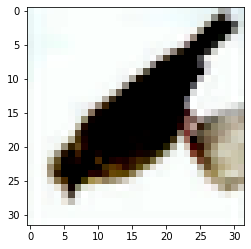

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


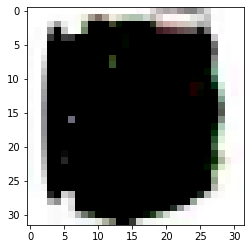

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


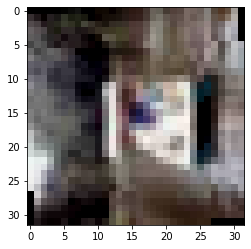

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


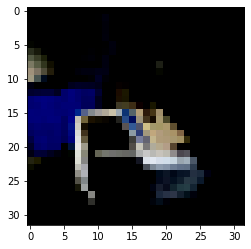

plane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


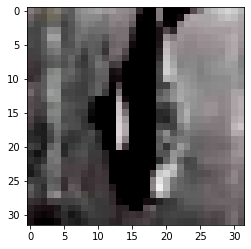

In [17]:
# Explore data
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [50]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 960)
        self.fc4 = nn.Linear(960, 640)
        self.fc5 = nn.Linear(640, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        x = F.relu(self.fc7(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc8(x), dim=1)

        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [51]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(1)
torch.cuda.current_device()


1

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [38]:
epochs = 33
steps = 0
print_every = 250
running_loss = 0

train_losses, validation_losses = [], []

model.to(device)

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            validation_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validationloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    validation_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          
            model.train()
            
            train_losses.append(running_loss/len(trainloader))
            validation_losses.append(validation_loss/len(validationloader))

            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Validation Loss: {:.3f}.. ".format(validation_loss/len(validationloader)),
              "Validation Accuracy: {:.3f}".format(accuracy/len(validationloader)))
            
            running_loss = 0
            


Epoch: 1/33..  Training Loss: 0.675..  Validation Loss: 1.987..  Validation Accuracy: 0.244
Epoch: 1/33..  Training Loss: 0.629..  Validation Loss: 1.909..  Validation Accuracy: 0.287
Epoch: 1/33..  Training Loss: 0.617..  Validation Loss: 1.839..  Validation Accuracy: 0.334
Epoch: 2/33..  Training Loss: 0.603..  Validation Loss: 1.825..  Validation Accuracy: 0.335
Epoch: 2/33..  Training Loss: 0.599..  Validation Loss: 1.809..  Validation Accuracy: 0.340
Epoch: 2/33..  Training Loss: 0.577..  Validation Loss: 1.771..  Validation Accuracy: 0.361
Epoch: 3/33..  Training Loss: 0.576..  Validation Loss: 1.726..  Validation Accuracy: 0.380
Epoch: 3/33..  Training Loss: 0.565..  Validation Loss: 1.741..  Validation Accuracy: 0.372
Epoch: 3/33..  Training Loss: 0.568..  Validation Loss: 1.719..  Validation Accuracy: 0.369
Epoch: 4/33..  Training Loss: 0.557..  Validation Loss: 1.696..  Validation Accuracy: 0.386
Epoch: 4/33..  Training Loss: 0.549..  Validation Loss: 1.714..  Validation Accu

Plot the training loss (and validation loss/accuracy, if recorded).

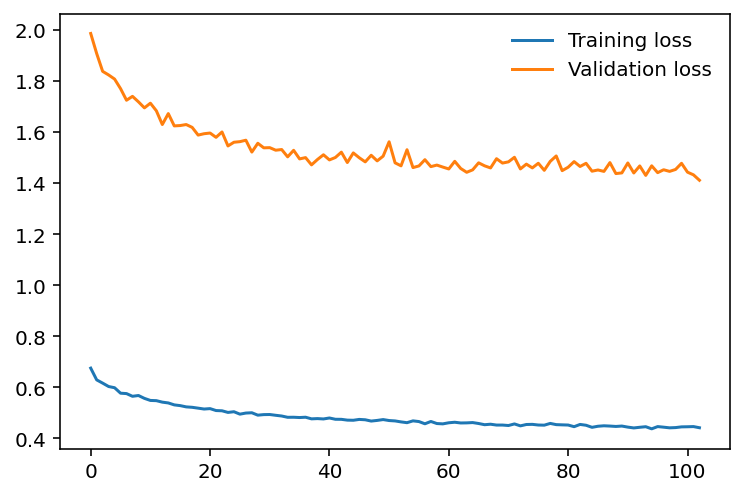

In [40]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [41]:
def view_classify(img, ps, version="CIFAR"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "CIFAR":
        ax2.set_yticklabels(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

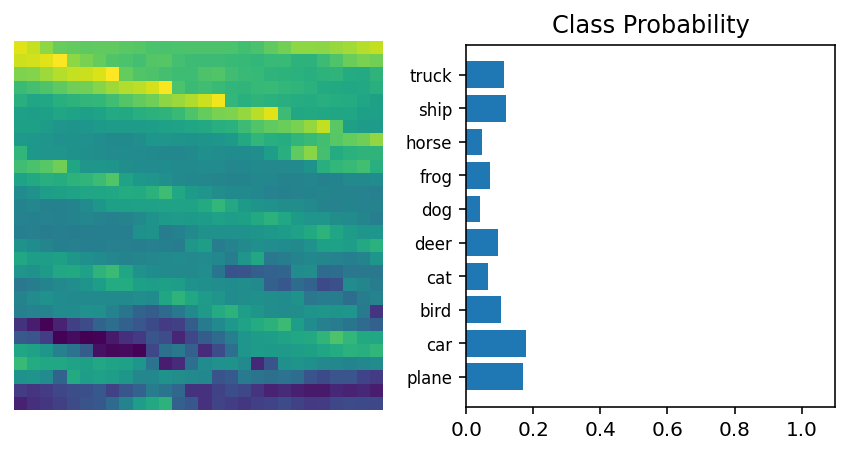

In [47]:
# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 3072)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
view_classify(img.view(3, 32, 32), ps, version='CIFAR')

In [45]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

correct = 0
total = 0

model.eval()

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images, labels in testloader:        
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 8000 test images: {100 * correct // total} %')

Accuracy of the network on the 8000 test images: 50 %


In [46]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 61.4 %
Accuracy for class: car   is 68.8 %
Accuracy for class: bird  is 22.1 %
Accuracy for class: cat   is 32.1 %
Accuracy for class: deer  is 49.4 %
Accuracy for class: dog   is 39.0 %
Accuracy for class: frog  is 58.3 %
Accuracy for class: horse is 54.9 %
Accuracy for class: ship  is 67.5 %
Accuracy for class: truck is 55.7 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [48]:
torch.save(model.state_dict(), 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

* The present model was developed with the PyTorch library using the “CIFAR-10” dataset which contains 50,000 images for training, 2,000 for validation and 8,000 images for testing. The images have a pixel resolution of 32x32 and 3 color channels. The model has a 50% accuracy rate on the test images. The model has more accuracy predicting planes, cars, frogs and ships, but it is not so accurate predicting birds, cats, and dogs. The model is relatively simple, with a small number of linear layers, and it does not implement convolutional layers or other more advanced techniques, so it still has ample room for improvement. For these reasons, it could be argued that developing an in-house solution, with even more accuracy, is possible and more recommendable than buying an external solution. 
